In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn
#from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm
import __init__

In [2]:
from src.ESM2embeddings import ESM2embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer


path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2.pth'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#BERT = ESM2embeddings(type_embedding = "facebook/esm2_t6_8M_UR50D", device = device)
Trainer = Trainer()

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence']
train, val, test = train_test_validation_splits(splits_meltome)

In [3]:
import torch
import esm


# Load ESM-2 model
"""
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D() #esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.to(device)

if torch.cuda.is_available() and device!='cpu':
    model = model.half()
model.eval()  # disables dropout for deterministic results
"""
pt_batch_size = 16

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

"""
def truncate(sequences, length):
    '''Function to truncate protein sequences at a given length'''
    num_truncated = len([seq for seq in sequences if len(seq) > length])
    print(num_truncated, 'sequences were too long and have been truncated to', length, 'AA')
    sequences = [seq[:length] for seq in sequences]
    
    return sequences

def esm2embedding(all_data, model, batch_converter, device, truncate_length=1000, layer_index=6):
    
    embeddings = torch.tensor([]).to(device)
    all_data.sequence = truncate(all_data.sequence.values, truncate_length)
    
    for i in tqdm(range(0,len(all_data), pt_batch_size)):
        batch = all_data.iloc[i:i+pt_batch_size]

        esm_data = list(zip(batch.index, batch.sequence))
        batch_labels, batch_strs, batch_tokens = batch_converter(esm_data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[layer_index])
        token_embeddings = results["representations"][layer_index]
        
        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        for i, tokens_len in enumerate(batch_lens):
            sequence_embeddings = token_embeddings[i, 1 : tokens_len - 1].mean(0).reshape(1,-1)
            embeddings = torch.cat([embeddings, sequence_embeddings])
        
        torch.cuda.empty_cache()
                
    return embeddings
"""




'\ndef truncate(sequences, length):\n    \'\'\'Function to truncate protein sequences at a given length\'\'\'\n    num_truncated = len([seq for seq in sequences if len(seq) > length])\n    print(num_truncated, \'sequences were too long and have been truncated to\', length, \'AA\')\n    sequences = [seq[:length] for seq in sequences]\n    \n    return sequences\n\ndef esm2embedding(all_data, model, batch_converter, device, truncate_length=1000, layer_index=6):\n    \n    embeddings = torch.tensor([]).to(device)\n    all_data.sequence = truncate(all_data.sequence.values, truncate_length)\n    \n    for i in tqdm(range(0,len(all_data), pt_batch_size)):\n        batch = all_data.iloc[i:i+pt_batch_size]\n\n        esm_data = list(zip(batch.index, batch.sequence))\n        batch_labels, batch_strs, batch_tokens = batch_converter(esm_data)\n        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)\n\n        \n        batch_tokens = batch_tokens.to(device)\n\n        with torch.no_gr

In [4]:
if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

    """batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                test.sequence.to_list(), 
                                                                                val.sequence.to_list(), 
                                                                                batch_size=2)"""
    print ("Creating Embeddings...")   
    train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
    torch.save(train_embeddings, path_train)
    test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
    torch.save(test_embeddings, path_test)
    val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
    torch.save(val_embeddings, path_val)
    print ("Loaded")
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load(path_train)
    test_embeddings = torch.load(path_test)
    val_embeddings = torch.load(path_val)
    print ("Loaded")
    
train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Loading Premade Embeddings...
Loaded


In [5]:
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 200
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 1184.749 val loss: 1127.570
epoch: 2 loss: 397.041 val loss: 503.354
epoch: 3 loss: 212.451 val loss: 229.834
epoch: 4 loss: 125.586 val loss: 136.130
epoch: 5 loss: 159.592 val loss: 116.376
epoch: 6 loss: 124.260 val loss: 113.024
epoch: 7 loss: 55.362 val loss: 112.342
epoch: 8 loss: 93.394 val loss: 112.456
epoch: 9 loss: 130.962 val loss: 112.704
epoch: 10 loss: 180.178 val loss: 112.235
epoch: 11 loss: 54.575 val loss: 111.029
epoch: 12 loss: 190.034 val loss: 84.177
epoch: 13 loss: 41.039 val loss: 64.996
epoch: 14 loss: 34.681 val loss: 54.220
epoch: 15 loss: 28.781 val loss: 47.959
epoch: 16 loss: 37.436 val loss: 44.435
epoch: 17 loss: 54.324 val loss: 42.610
epoch: 18 loss: 23.104 val loss: 41.948
epoch: 19 loss: 40.668 val loss: 40.828
epoch: 20 loss: 36.733 val loss: 40.695
epoch: 21 loss: 33.449 val loss: 39.922
epoch: 22 loss: 30.530 val loss: 39.715
epoch: 23 loss: 49.921 val loss: 39.412
epoch: 24 loss: 38.042 val loss: 39.428
epoch: 25 loss: 26.400 val 

MSE: tensor(39.1657, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.2583, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(2.1322, device='cuda:0', grad_fn=<SqrtBackward0>)


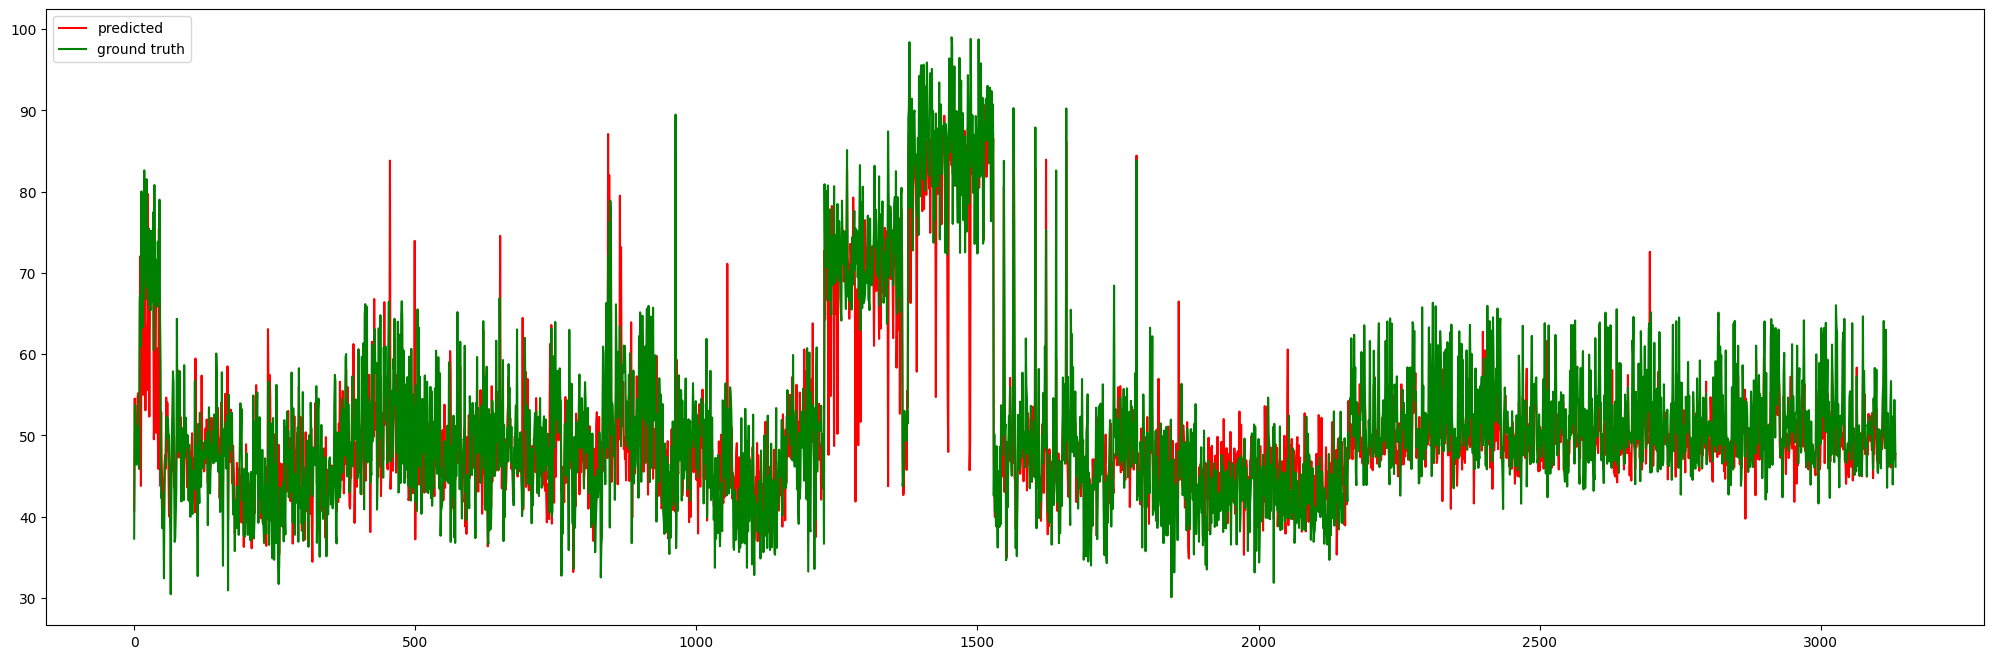

In [7]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)
from src.utilities import plot_results

plot_results( outcome, test_labels) 